In [1]:
import sys
sys.path.append('../')

In [316]:
from functools import partial
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pp
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import (metrics, model_selection, multiclass, decomposition, 
                     cluster, svm, ensemble, neighbors, naive_bayes, 
                     semi_supervised, gaussian_process)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline, make_union
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from sklearn_pandas import DataFrameMapper, gen_features
from tools.constants import SEED
import tools
import tools.preprocessing as pp_tools
import tools.modelling as modelling_tools
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sns.set()
%matplotlib inline

In [358]:
DATADIR = Path('../data')
RAW_DATADIR = DATADIR / 'raw'
MODEL_DIR = Path('../models')

In [352]:
raw_data = tools.read_raw_data(RAW_DATADIR / 'train.csv')
train, test = tools.train_test_split(raw_data)
train_features = train.drop('Target', axis='columns')
train_labels = train['Target'].values
is_head_of_household = train_features['parentesco1'].values

test_features = test.drop('Target', axis='columns')
test_labels = test['Target'].values
is_head_of_household_test = test_features['parentesco1'].values

# I - Cleanup

TODO:
   * drop squares
   * drop rejected
   * inpute missing values
   * aggregate on household head

In [134]:
# Alwasys dropped.
dropped_cols = [
    'Id',
    'idhogar',
    'agesq',
    'SQBage',
    'SQBdependency',
    'SQBedjefe',
    'SQBescolari',
    'SQBhogar_nin',
    'SQBhogar_total',
    'SQBmeaned',
    'SQBovercrowding',
#     'dependency',
    'edjefe',
    'edjefa'
]

high_na_cols = [
    'v2a1',
    'v18q1',
    'rez_esc',
    'meaneduc'
]

continuous_cols = [
    'v2a1', 'rooms', 'v18q1', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2',
       'r4m3', 'r4t1', 'r4t2', 'r4t3', 'tamhog', 'tamviv', 'escolari',
       'rez_esc', 'hhsize', 'elimbasu5', 'hogar_nin', 'hogar_adul',
       'hogar_mayor', 'hogar_total',
       'meaneduc', 'bedrooms', 'overcrowding', 'qmobilephone', 'age',
]

# We've identified high skew in the distribution of those variables.
skewed_cols = ['v2a1', 'age']

# From the profiling report, we know that those variables are highly correlated.
compression_candidates = [
    'hogar_total', 'hhsize', 'r4t3', 'tamhog', 'tamviv'
]

# Columns containing information only relevant for the individual that may be noise
# at household level. May or may not be dropped
individual_cols = [
    'parentesco1',     
    'parentesco2', 
    'parentesco3', 
    'parentesco4', 
    'parentesco5', 
    'parentesco6', 
    'parentesco7', 
    'parentesco8', 
    'parentesco9', 
    'parentesco10', 
    'parentesco11', 
    'parentesco12'
]

In [242]:
class ClusterIndexTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cluster):
        self.cluster = cluster
    def fit(self, X, y=None):
        self.cluster.fit(X)
        return self
        
    def transform(self, X):
        cluster_indices = self.cluster.predict(X)
        return cluster_indices.reshape(-1, 1)
    

class VulnerabilityIndicator(BaseEstimator, TransformerMixin):
    '''
    Adds a metafeature indicating if the datapoint
    belongs to a vulnerable household. Used to guide the downstream classifier.
    '''
    def __init__(self, loss = 'hinge', random_state=None):
        self.loss = loss
        self.random_state = random_state
        
    def fit(self, X, y):
        self.clf_ = SGDClassifier(loss=self.loss, random_state=self.random_state)
        y_ = y != 4
        self.clf_.fit(X, y_)
        return self
        
    def transform(self, X):
        y_hat = self.clf_.predict(X)
        return y_hat.reshape(-1, 1)

In [250]:
imputer_def = gen_features(
    columns=high_na_cols, classes=[
        {'class': pp.FunctionTransformer, 'func': pp_tools.as_2darray, 'validate': False},
        {'class': SimpleImputer, 'strategy': 'median'}
    ]
)

standardize_def = gen_features(
    columns=continuous_cols, classes=[
        {'class': pp.FunctionTransformer, 'func': pp_tools.as_2darray, 'validate': False},
        pp.StandardScaler
    ]
)

features_def = [
    ('dependency', [
        pp.FunctionTransformer(pp_tools.code_dependents, validate=False), 
        pp.OneHotEncoder()
    ]),
    *standardize_def
]

preprocess = make_pipeline(
    pp_tools.ColumnSelector(columns=dropped_cols, drop=True),
    pp_tools.ColumnSelector(columns=individual_cols, drop=True),
    DataFrameMapper(imputer_def, input_df=True, default=None, df_out=True),
    DataFrameMapper(features_def, input_df=True, default=None, df_out=True),
    make_column_transformer(
        (pp.PowerTransformer(standardize=False), skewed_cols),
        (decomposition.PCA(n_components=2, random_state=SEED), compression_candidates),
    remainder='passthrough'),
    make_union(
        pp.FunctionTransformer(validate=True),
        pp_tools.VulnerabilityIndicator(random_state=SEED)
    )
    
)

binarizer = pp.LabelBinarizer()

In [251]:
X = preprocess.fit_transform(train_features, train_labels)

y = binarizer.fit_transform(train_labels)

In [252]:
train_features.columns

Index(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q',
       'v18q1', 'r4h1',
       ...
       'age', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe',
       'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned',
       'agesq'],
      dtype='object', length=142)

In [253]:
X[0, :]

array([-0.13759397,  0.29087248,  3.74713438, -0.07676544,  1.        ,
        0.        ,  0.        ,  1.39864066, -0.23126609,  0.90529941,
        2.3801814 ,  2.58991345,  0.86128959, -0.71139495, -0.05130534,
        1.15387734,  1.25065932, -0.47596065, -0.1846431 ,  0.        ,
        2.62931906, -0.50948887, -0.47590442,  0.17608057,  2.38906639,
       -0.24891447, -0.55882437,  0.        ,  0.        ,  1.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  1.  

In [254]:
weights = 1 / (y.sum(axis=0) / y.sum())
class_weight = weights / weights.sum()
class_weight = {k:w for k, w in zip(np.arange(1, 5), class_weight)}
class_weight

{1: 0.4498093822972523,
 2: 0.21258596784627573,
 3: 0.28095642906674295,
 4: 0.056648220789729024}

## Baseline Linear Model

mean score: 0.3772843068354756, stddev: 0.01897709743545357


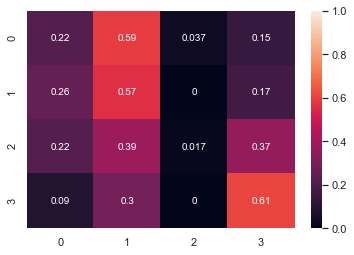

In [272]:
clf = multiclass.OneVsRestClassifier(SGDClassifier(loss='modified_huber', 
                                                   random_state=SEED)
                                    )

score_mean, score_std = modelling_tools.cross_validate_estimator(clf, X, y, sample_weight=is_head_of_household)
print(f'mean score: {score_mean}, stddev: {score_std}')
cm = modelling_tools.show_confusion_matrix(clf, X, y, binarizer=binarizer, sample_weight=is_head_of_household)

## SVM

mean score: 0.41532412263986257, stddev: 0.022269602922654324


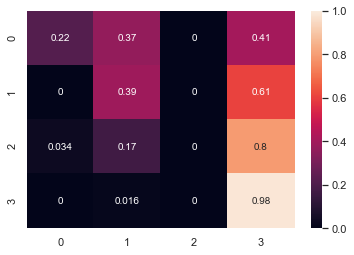

In [274]:
clf = multiclass.OutputCodeClassifier(svm.SVC(random_state=SEED, gamma='scale'), random_state=SEED, code_size=2, n_jobs=-1)

score_mean, score_std = modelling_tools.cross_validate_estimator(clf, X, train_labels, sample_weight=is_head_of_household)
print(f'mean score: {score_mean}, stddev: {score_std}')
cm = modelling_tools.show_confusion_matrix(clf, X, train_labels, sample_weight=is_head_of_household)

## Neighbourhood based algorithms

mean score: 0.659548421065152, stddev: 0.037231351425998496


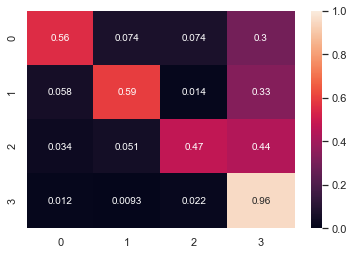

In [278]:
clf = neighbors.KNeighborsClassifier(weights='distance', n_jobs=-1)
score_mean, score_std = modelling_tools.cross_validate_estimator(clf, X, train_labels, sample_weight=is_head_of_household)
print(f'mean score: {score_mean}, stddev: {score_std}')
cm = modelling_tools.show_confusion_matrix(clf, X, train_labels, sample_weight=is_head_of_household)

/Users/ndiladjimsoungadoy/Personal/source_repository/costa-rican-household-poverty-prediction/.venv/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:201: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/ndiladjimsoungadoy/Personal/source_repository/costa-rican-household-poverty-prediction/.venv/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:201: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/ndiladjimsoungadoy/Personal/source_repository/costa-rican-household-poverty-prediction/.venv/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:201: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/Users/ndiladjimsoungadoy/Personal/source_repository/costa-rican-household-poverty-prediction/.venv/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:201: RuntimeWarning: invalid val

mean score: 0.7753473995503206, stddev: 0.007099069698536677


/Users/ndiladjimsoungadoy/Personal/source_repository/costa-rican-household-poverty-prediction/.venv/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:201: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


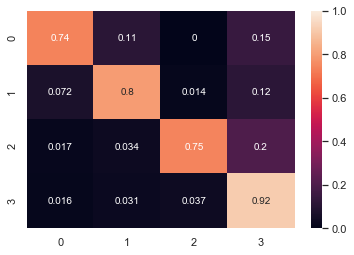

In [280]:
clf = semi_supervised.LabelSpreading(n_jobs=-1)
score_mean, score_std = modelling_tools.cross_validate_estimator(clf, X, train_labels, sample_weight=is_head_of_household)
print(f'mean score: {score_mean}, stddev: {score_std}')
cm = modelling_tools.show_confusion_matrix(clf, X, train_labels, sample_weight=is_head_of_household)

## Ensembles

mean score: 0.5045834798249619, stddev: 0.02368518281961784


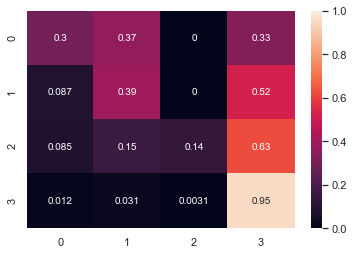

In [281]:
clf = ensemble.GradientBoostingClassifier(random_state=SEED)
score_mean, score_std = modelling_tools.cross_validate_estimator(clf, X, train_labels, sample_weight=is_head_of_household)
print(f'mean score: {score_mean}, stddev: {score_std}')
cm = modelling_tools.show_confusion_matrix(clf, X, train_labels, sample_weight=is_head_of_household)

mean score: 0.7619966909816862, stddev: 0.011793235174899048


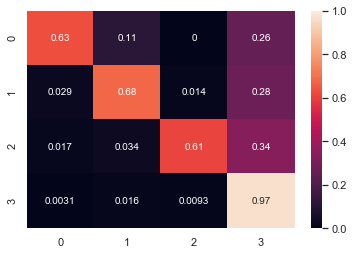

In [287]:
clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=SEED)
score_mean, score_std = modelling_tools.cross_validate_estimator(clf, X, train_labels, sample_weight=is_head_of_household)
print(f'mean score: {score_mean}, stddev: {score_std}')
cm = modelling_tools.show_confusion_matrix(clf, X, train_labels, sample_weight=is_head_of_household)

mean score: 0.653749227006759, stddev: 0.04613278087227369


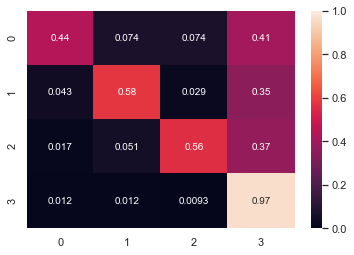

In [291]:
clf = ensemble.BaggingClassifier(base_estimator=neighbors.KNeighborsClassifier(weights='distance'), n_estimators=25, random_state=SEED, n_jobs=-1)
score_mean, score_std = modelling_tools.cross_validate_estimator(clf, X, train_labels, sample_weight=is_head_of_household)
print(f'mean score: {score_mean}, stddev: {score_std}')
cm = modelling_tools.show_confusion_matrix(clf, X, train_labels, sample_weight=is_head_of_household)

## Tuning of most promising classifiers

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LabelSpreading(alpha=0.2, gamma=20, kernel='rbf',
                                            max_iter=30, n_jobs=-1,
                                            n_neighbors=7, tol=0.001),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13830d850>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13830dd50>},
                   pre_dispatch='2*n_jobs', random_state=93, refit=True,
                   return_train_score=False, scoring='f1_macro', verbose=0)

Model with rank: 1
Mean validation score: 0.844 (std: 0.005)
Parameters: {'alpha': 0.4373567218968436, 'gamma': 2}

Model with rank: 2
Mean validation score: 0.844 (std: 0.006)
Parameters: {'alpha': 0.6063543377764754, 'gamma': 5}

Model with rank: 3
Mean validation score: 0.844 (std: 0.006)
Parameters: {'alpha': 0.5036970188808332, 'gamma': 10}

score: 1.0


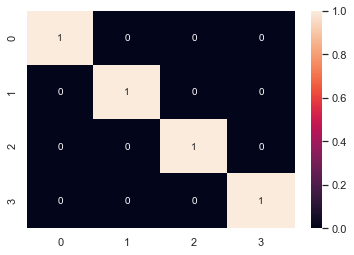

In [323]:
label_spreading_clf = semi_supervised.LabelSpreading(n_jobs=-1)
param_distributions={
    'alpha': stats.uniform(),
    'gamma': stats.randint(1, 30),
}


label_spreading_tuning_job = model_selection.RandomizedSearchCV(label_spreading_clf, param_distributions, n_jobs=-1, n_iter=10, cv=5, random_state=SEED, scoring='f1_macro')
label_spreading_tuning_job.fit(X, train_labels)
modelling_tools.tuning_report(label_spreading_tuning_job.cv_results_)
modelling_tools.test_report(label_spreading_tuning_job.best_estimator_, X, train_labels, sample_weight=is_head_of_household)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=100, n_jobs=-1,
                                                    oob

Model with rank: 1
Mean validation score: 0.886 (std: 0.009)
Parameters: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.884 (std: 0.008)
Parameters: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.883 (std: 0.009)
Parameters: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 3}

score: 0.9979405582516769


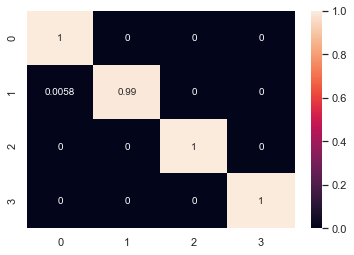

In [348]:
random_forest_clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
param_distributions={
    "max_depth": [3, None],
    "min_samples_split": stats.randint(2, 5),
    'max_features': ['sqrt', 'log2', None],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

random_forest_tuning_job = model_selection.RandomizedSearchCV(random_forest_clf, param_distributions, n_jobs=-1, n_iter=10, cv=5, random_state=SEED, scoring='f1_macro')
random_forest_tuning_job.fit(X, train_labels)
report(random_forest_tuning_job.cv_results_)
modelling_tools.test_report(random_forest_tuning_job.best_estimator_, X, train_labels, sample_weight=is_head_of_household)

## Comments: 
Both tuned models perform at similar level. It is worth evaluating both on the test set and taking a final decision based on the business needs in production

## Final Evaluation on test set

In [351]:
X_test = preprocess.transform(test)

score: 0.8442800993838891


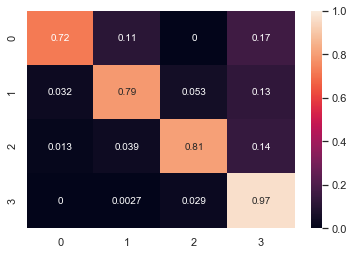

In [353]:
modelling_tools.test_report(label_spreading_tuning_job.best_estimator_, X_test, test_labels, sample_weight=is_head_of_household_test)

score: 0.8844138398635792


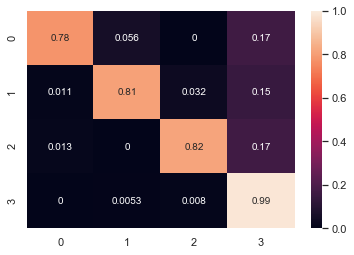

In [356]:
modelling_tools.test_report(random_forest_tuning_job.best_estimator_, X_test, test_labels, sample_weight=is_head_of_household_test)

## Serialization

In [364]:
random_forest_pipeline

{'pipeline': Pipeline(memory=None,
          steps=[('columnselector-1',
                  ColumnSelector(columns=['Id', 'idhogar', 'agesq', 'SQBage',
                                          'SQBdependency', 'SQBedjefe',
                                          'SQBescolari', 'SQBhogar_nin',
                                          'SQBhogar_total', 'SQBmeaned',
                                          'SQBovercrowding', 'edjefe',
                                          'edjefa'],
                                 drop=True)),
                 ('columnselector-2',
                  ColumnSelector(columns=['parentesco1', 'parentesco2',
                                          'parentesco3', 'parentesco4',
                                          'parentesco...
                  FeatureUnion(n_jobs=None,
                               transformer_list=[('functiontransformer',
                                                  FunctionTransformer(accept_sparse=False,
              

In [375]:
random_forest_pipeline = make_pipeline(
    preprocess,
    random_forest_tuning_job.best_estimator_
)
tools.save_model(estimator=random_forest_pipeline, metadata={'params': random_forest_tuning_job.best_params_}, name='random_forest', dirpath=MODEL_DIR, overwrite=True)

In [376]:
label_spreading_pipeline = make_pipeline(
    preprocess,
    label_spreading_tuning_job.best_estimator_
)
tools.save_model(estimator=label_spreading_pipeline, metadata={'params': label_spreading_tuning_job.best_params_}, name='label_spreading', dirpath=MODEL_DIR, overwrite=True)